In [7]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Leer el archivo CSV
file_path = '../../datos/Raw/contratos_dnp_2020_v1.csv'
df_contratos_v1 = pd.read_csv(file_path)

# Aplicar el filtro
df_contratos_v1 = df_contratos_v1[df_contratos_v1['valor_del_contrato'] != 2870993010534]

# Convertir las columnas de fecha al formato datetime
date_columns = ['fecha_de_firma', 'fecha_de_inicio_del_contrato', 'fecha_de_fin_del_contrato']
for col in date_columns:
    df_contratos_v1[col] = pd.to_datetime(df_contratos_v1[col])

# Calcular la duración del contrato en días
df_contratos_v1['duracion_contrato_dias'] = (df_contratos_v1['fecha_de_fin_del_contrato'] - df_contratos_v1['fecha_de_inicio_del_contrato']).dt.days.fillna(0).replace(0, 1)

# Convertir la columna 'duracion_contrato_dias' a numérica
df_contratos_v1['duracion_contrato_dias'] = df_contratos_v1['duracion_contrato_dias'].astype(int)

# Calcular el valor del contrato por día
df_contratos_v1['valor_contrato_por_dia'] = df_contratos_v1['valor_del_contrato'] / df_contratos_v1['duracion_contrato_dias']

# Extraer el mes de la fecha de firma
df_contratos_v1['fecha_de_firma_month'] = df_contratos_v1['fecha_de_firma'].dt.month

# Definir las columnas numéricas y categóricas
numeric_features = ['valor_del_contrato', 'fecha_de_firma_month', 'duracion_contrato_dias', 'valor_contrato_por_dia']
categorical_features = ['ciudad', 'tipo_de_contrato', 'estado_contrato', 'modalidad_de_contratacion']

# Definir las transformaciones para las características numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Definir las transformaciones para las características categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar las transformaciones en un preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Definir el modelo de clustering
kmeans = KMeans(n_clusters=3, random_state=42)

# Construir el pipeline completo
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('kmeans', kmeans)])

# Entrenar el modelo con los datos
pipeline.fit(df_contratos_v1)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['valor_del_contrato',
                                                   'fecha_de_firma_month',
                                                   'duracion_contrato_dias',
                                                   'valor_contrato_por_dia']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ciudad', 'tipo_de_contrato',
                                                   'estado_contrato',
                                                   'modalidad_de_contratacion'])])),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [8]:
# Crear nuevos datos con todas las columnas requeridas
nuevos_datos = pd.DataFrame({'ciudad': ['Bogota'],
                             'tipo_de_contrato': ['Prestación de servicios'],
                             'estado_contrato': ['En ejecución'],
                             'modalidad_de_contratacion': ['Regimen especial'],
                             'fecha_de_firma_month': [1],  # Se debe proporcionar el mes de la fecha de firma
                             'duracion_contrato_dias': [119],
                             'valor_del_contrato': [37724000],  # Asegúrate de que esta columna exista
                             'valor_contrato_por_dia': [317008]})  # Asegúrate de que esta columna exista

# Realizar la predicción
prediccion = pipeline.predict(nuevos_datos)
print("Predicción para los nuevos datos:", prediccion)

Predicción para los nuevos datos: [0]


In [9]:
# Obtener las etiquetas de cluster asignadas por DBSCAN
etiquetas_clust = pipeline.named_steps['kmeans'].labels_

# Agregar las etiquetas de cluster al DataFrame original
df_contratos_v1['cluster'] = etiquetas_clust

# Guardar el DataFrame con las etiquetas de cluster
df_contratos_v1.to_excel('../../datos/Raw/contratos_dnp_2020_cluster.xlsx', index=False)

In [10]:
df_contratos_v1['cluster'].value_counts()

cluster
0    3488
2    1787
1       1
Name: count, dtype: int64

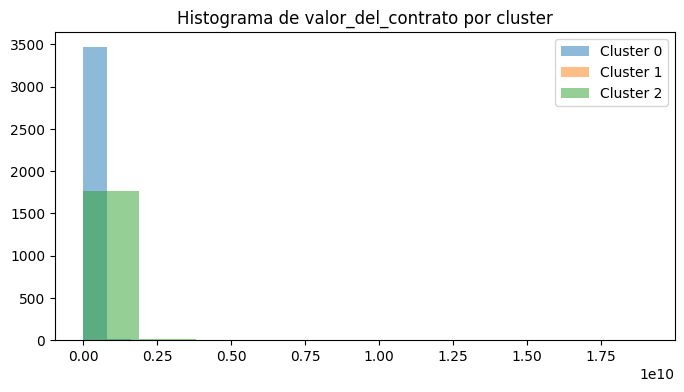

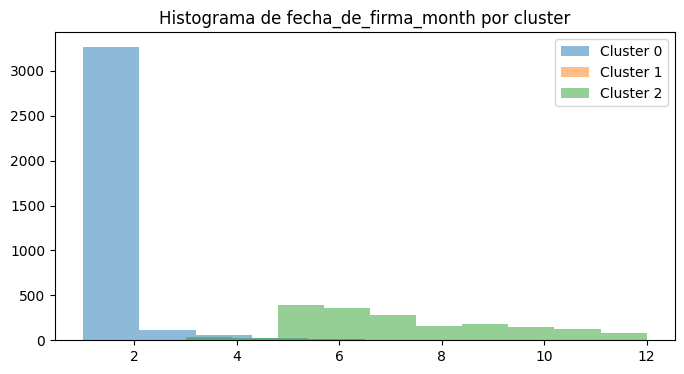

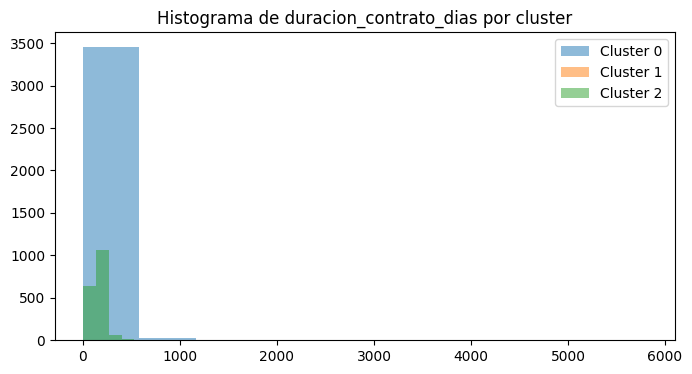

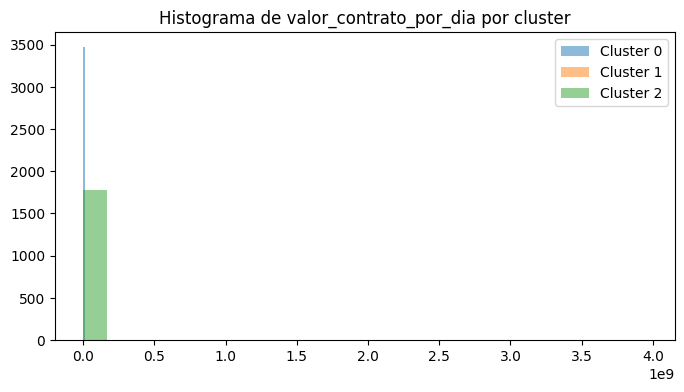

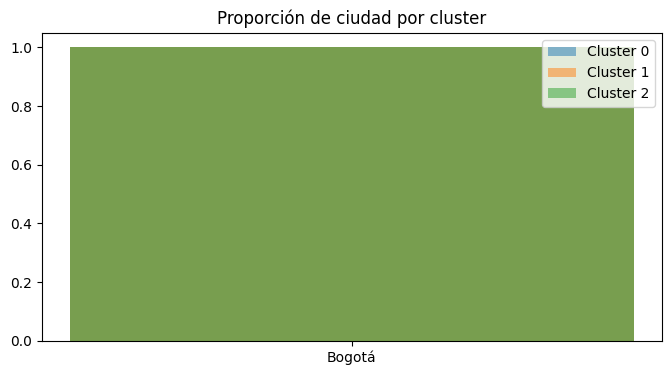

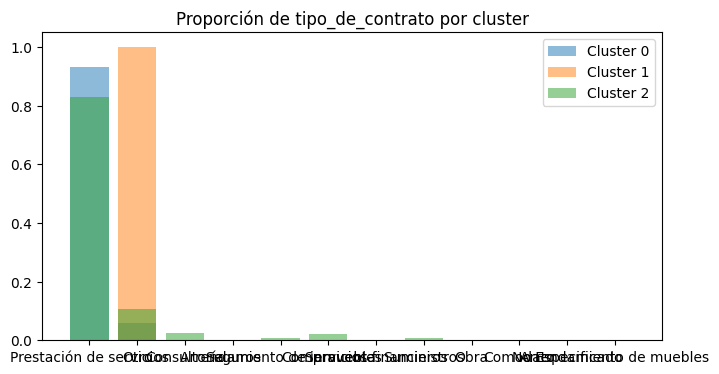

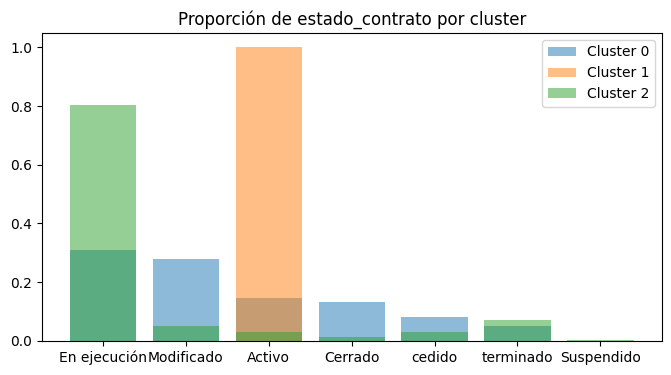

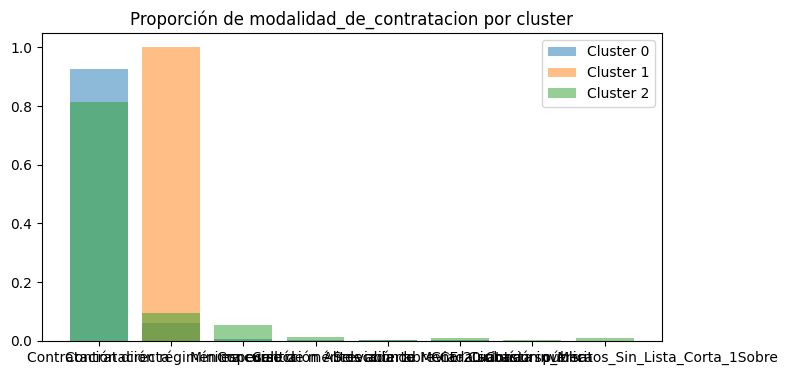

In [11]:
import matplotlib.pyplot as plt

# Histogramas para características numéricas
for feature in numeric_features:
    plt.figure(figsize=(8, 4))
    for cluster in range(3):  # Cambia 3 por el número de clústeres
        plt.hist(df_contratos_v1[df_contratos_v1['cluster'] == cluster][feature], alpha=0.5, label=f'Cluster {cluster}')
    plt.title(f'Histograma de {feature} por cluster')
    plt.legend()
    plt.show()

# Gráficos de barras para características categóricas
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    for cluster in range(3):  # Cambia 3 por el número de clústeres
        counts = df_contratos_v1[df_contratos_v1['cluster'] == cluster][feature].value_counts(normalize=True)
        plt.bar(counts.index, counts.values, alpha=0.5, label=f'Cluster {cluster}')
    plt.title(f'Proporción de {feature} por cluster')
    plt.legend()
    plt.show()
